# ClimateNet AR Analysis: CESM data subset for ARs

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
import pandas as pd

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up
cluster.scale(30) # 25 (at least) for processing 3hrly data
#cluster.scale(10) # for other tasks

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

Task exception was never retrieved
future: <Task finished name='Task-970293' coro=<Client._gather.<locals>.wait() done, defined at /glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:2208> exception=AllExit()>
Traceback (most recent call last):
  File "/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py", line 2217, in wait
    raise AllExit()
distributed.client.AllExit


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:37199,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/Casper CPU CCR/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## CESM ARs

### Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

### Set regional bounds

In [5]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,255)

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

### CESM historical simulation

In [7]:
hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [8]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
#hist_paths

#### Read in masks with preprocessing

In [9]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 482 ms, sys: 62.4 ms, total: 544 ms
Wall time: 16.2 s


#### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [10]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [11]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)

### CESM RCP2.6 simulation

In [12]:
rcp26_yrs = [str(i) for i in range(2006,2016)]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks/" for y in rcp26_yrs]
#rcp26_folders = ["BRCP26C5CN/"+y+"/masks_v2/" for y in rcp26_yrs] # updated data processing (3hrly PSL)
rcp26_folders = ["BRCP26C5CN/"+y+"/masks_unwgt/" for y in rcp26_yrs] # unweighted means/std

In [13]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp26_paths = [cesm_cnet_filepath+rcp26_folders[i]+cnet_file for i,f in enumerate(rcp26_folders)]
#rcp26_paths

#### Read in masks with preprocessing

In [14]:
%%time
cnet_rcp26 = xr.open_mfdataset(rcp26_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 715 ms, sys: 58.3 ms, total: 773 ms
Wall time: 19.5 s


### Combine historical/RCP2.6

In [15]:
cnet_hist_rcp26 = xr.concat([cnet_hist, cnet_rcp26], dim='time')
#cnet_hist_rcp26

### Define ARs

In [16]:
cesm_AR = cnet_hist_rcp26.clip(min=1)-1
cesm_AR

<xarray.DataArray 'masks' (time: 46720, lat: 170, lon: 241)>
dask.array<sub, shape=(46720, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00

### CESM RCP8.5 simulation

In [17]:
rcp85_yrs = [str(i) for i in range(2086,2101)]
#rcp85_folders = ["BRCP85C5CN/"+y+"/masks_unwgt/" for y in rcp85_yrs] # unweighted means/std
rcp85_folders = ["BRCP85C5CN/"+y+"/masks_rcp85config/" for y in rcp85_yrs] # RCP8.5 data used to calculate means/std in config file (unweighted)

In [19]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
rcp85_paths = [cesm_cnet_filepath+rcp85_folders[i]+cnet_file for i,f in enumerate(rcp85_folders)]
#rcp85_paths

### Read in masks with preprocessing

In [20]:
%%time
cnet_rcp85 = xr.open_mfdataset(rcp85_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 638 ms, sys: 43.4 ms, total: 682 ms
Wall time: 13 s


In [21]:
cesm_rcp85_AR = cnet_rcp85.clip(min=1)-1
cesm_rcp85_AR

<xarray.DataArray 'masks' (time: 43800, lat: 170, lon: 241)>
dask.array<sub, shape=(43800, 170, 241), dtype=int64, chunksize=(500, 170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00

## CESM 3hrly data

In [25]:
cesm_data_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/"

In [50]:
hist_folder = "B20TRC5CN/"
rcp26_folder = "BRCP26C5CN/"
rcp85_folder = "BRCP85C5CN/"

In [51]:
hist_yrs = [str(i) for i in range(2000,2006)]
rcp26_yrs = [str(i) for i in range(2006,2016)]
rcp85_yrs = [str(i) for i in range(2086,2101)]

In [28]:
cesm_files = '*.nc'
hist_paths = [cesm_data_path+hist_folder+y+'/'+cesm_files for y in hist_yrs]
#hist_paths

In [29]:
rcp26_paths = [cesm_data_path+rcp26_folder+y+'/'+cesm_files for y in rcp26_yrs]
#rcp26_paths

In [53]:
rcp85_paths = [cesm_data_path+rcp85_folder+y+'/'+cesm_files for y in rcp85_yrs]
#rcp85_paths

### Preprocessing functions to subset variables

In [ ]:
# this doesn't work...
#def preprocess_data(ds):
#    return ds['TMQ','U850','V850','PSL'].sel(lat=lat_bounds,lon=lon_bounds)

In [35]:
# trying a different way from xarray open_mfdataset docs
from functools import partial
def _preprocess(x, lon_bnds, lat_bnds):
    return x.sel(lon=lon_bnds, lat=lat_bnds)

partial_func = partial(_preprocess, lon_bnds=lon_bounds, lat_bnds=lat_bounds)

In [ ]:
# if trouble reading in all vars at the same time, can create separate functions
def preprocess_TMQ(ds):
    return ds['TMQ'].sel(lat=lat_bounds,lon=lon_bounds)

def preprocess_U850(ds):
    return ds['U850'].sel(lat=lat_bounds,lon=lon_bounds)

def preprocess_V850(ds):
    return ds['V850'].sel(lat=lat_bounds,lon=lon_bounds)

def preprocess_PSL(ds):
    return ds['PSL'].sel(lat=lat_bounds,lon=lon_bounds)

### Read in historical files with preprocessing function
`xr.open_mfdataset` won't take a list of paths with wildcards, so have to feed each one and then concat\
There may be a fast way with some sort of list expansion / glob ?

`data_vars = "minimal"` seems to really increase read in time, not a good solution\
Instead use `drop_variables` to reduce data size. It also sped up this step a bit.

In [43]:
# first item is a coordinate, rest of the list are data variables
dv = ['slat','time_bnds','lat_bnds','lon_bnds','w_stag','gw','ch4vmr','co2vmr','date','datesec','f11vmr','f12vmr','n2ovmr','ndcur','nscur','nsteph','sol_tsi']

In [44]:
%%time
cesm_hist_list = []
for i,f in enumerate(hist_paths):
    #print(i)    
    cesm_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine='nested', drop_variables=dv, chunks={'time':500}, parallel=True, preprocess=partial_func)
    cesm_hist_list.append(cesm_hist_temp)
cesm_hist = xr.concat(cesm_hist_list, dim='time')
cesm_hist

CPU times: user 1min 51s, sys: 4.14 s, total: 1min 55s
Wall time: 2min 7s


<xarray.Dataset>
Dimensions:  (time: 17520, lat: 170, lon: 241)
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
Data variables:
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    PSL      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [46]:
timeshift = cesm_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [47]:
cesm_hist_final = cesm_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cesm_hist_final

<xarray.Dataset>
Dimensions:  (lat: 170, lon: 241, time: 17520)
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Data variables:
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    PSL      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Read in RCP26

In [48]:
%%time
cesm_rcp26_list = []
for i,f in enumerate(rcp26_paths):
    print(i)    
    cesm_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", drop_variables=dv, chunks={'time':500}, parallel=True, preprocess=partial_func)
    cesm_rcp26_list.append(cesm_rcp26_temp)
cesm_rcp26 = xr.concat(cesm_rcp26_list, dim='time')
cesm_rcp26

0
1
2
3
4
5
6
7
8
9
CPU times: user 3min 3s, sys: 8.43 s, total: 3min 11s
Wall time: 3min 38s


<xarray.Dataset>
Dimensions:  (time: 29200, lat: 170, lon: 241)
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
Data variables:
    PSL      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    np:                         4
    ne:                         120
    case:                       b.e13.BRCP26C5CN.ne120_g16.003
    ...                         ...
    remap_version:              4.7.9
    NCO:                        netCDF Operators version 4.7.9 (Homepage = ht...
    map_file:                   /glade/p/cgd/amp/jet/mapfiles/map_ne120_to_dl...
    input_file:                 /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    history_of_appended_files:  Mon Apr  3 10:28:39 2023: Appended file 2006_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Combine historical/rcp2.6

In [49]:
cesm_data = xr.concat([cesm_hist_final, cesm_rcp26], dim='time')
cesm_data

<xarray.Dataset>
Dimensions:  (lat: 170, lon: 241, time: 46720)
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Data variables:
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    PSL      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### RCP8.5

In [54]:
%%time
cesm_rcp85_list = []
for i,f in enumerate(rcp85_paths):
    print(i)    
    cesm_rcp85_temp = xr.open_mfdataset(rcp85_paths[i], concat_dim='time', combine="nested", drop_variables=dv, chunks={'time':500}, parallel=True, preprocess=partial_func)
    cesm_rcp85_list.append(cesm_rcp85_temp)
cesm_rcp85 = xr.concat(cesm_rcp85_list, dim='time')
cesm_rcp85

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
CPU times: user 4min 35s, sys: 12.3 s, total: 4min 47s
Wall time: 5min 24s


<xarray.Dataset>
Dimensions:  (time: 43800, lon: 241, lat: 170)
Coordinates:
  * time     (time) object 2086-01-01 00:00:00 ... 2100-12-31 21:00:00
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
Data variables:
    TMQ      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    PSL      (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (time, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
Attributes: (12/23)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    remap_script:               ncremap
    remap_version:              4.7.9
    map_file:                   /glade/campaign/cgd/amp/jet/ClimateNet/data_p...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...
    ...                         ...
    host:                       nid02781
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /global/project/projectdirs/ccsm1/inputdata/a...
    topography_file:            /global/project/projectdirs/ccsm1/inputdata/a...
    history_of_appended_files:  Mon Apr  3 13:13:47 2023: Appended file outpu...

## CESM data and ARs

In [55]:
cesm_data_AR = cesm_data.where(cesm_AR==1)
#cesm_data_AR

In [56]:
cesm_data_rcp85_AR = cesm_rcp85.where(cesm_rcp85_AR==1)

In [57]:
cesm_data_AR_smean = cesm_data_AR.groupby('time.season').mean(dim='time')
cesm_data_rcp85_AR_smean = cesm_data_rcp85_AR.groupby('time.season').mean(dim='time')

#### These steps are very slow, may need to do some intermediate saving of netcdf and read in?
Also running out of hub memory (16GB)

In [60]:
%%time
cesm_data_AR_smean = cesm_data_AR_smean.persist()

CPU times: user 27min 7s, sys: 21.6 s, total: 27min 29s
Wall time: 27min 29s


/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 143.97 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [61]:
%%time
cesm_data_rcp85_AR_smean = cesm_data_rcp85_AR_smean.persist()

CPU times: user 22min 54s, sys: 20.4 s, total: 23min 14s
Wall time: 23min 12s


/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 133.83 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Save out files

In [83]:
cesm_data_AR_smean

<xarray.Dataset>
Dimensions:  (season: 4, lat: 170, lon: 241)
Coordinates:
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    TMQ      (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    PSL      (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

#### Must have not fully persisted because I'm getting weird netCDF errors now

In [81]:
%%time
cesm_data_AR_smean.to_netcdf('/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/CESM_hist_allvars_AR.nc')

RuntimeError: NetCDF: Not a valid ID

## Comparing CESM RCP8.5 / HIST

#### Datasets to compare
* `cesm_data_AR_smean`
* `cesm_data_rcp85_AR_smean`

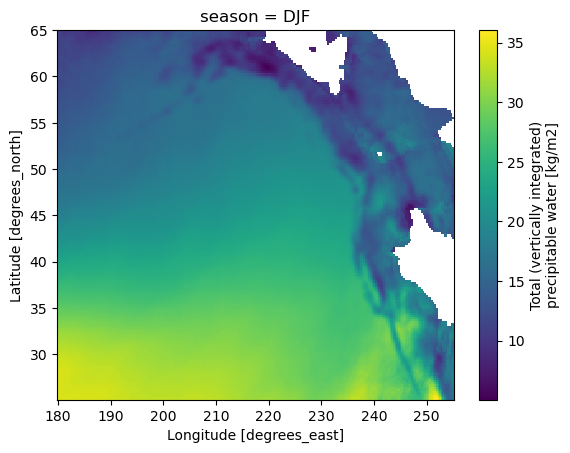

In [82]:
# cesm will have missing data where there aren't ARs at any timepoint
cesm_data_AR_smean['TMQ'].sel(season='DJF').plot();

In [80]:
cesm_data_rcp85_AR_smean['TMQ'].sel(season='DJF')

<xarray.DataArray 'TMQ' (lat: 170, lon: 241)>
dask.array<getitem, shape=(170, 241), dtype=float32, chunksize=(170, 241), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
    season   <U3 'DJF'
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2022-12-20
    cell_measures:  area: area

In [63]:
diff_smean = cesm_data_rcp85_AR_smean - cesm_data_AR_smean
diff_smean

<xarray.Dataset>
Dimensions:  (lon: 241, lat: 170, season: 4)
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 254.1 254.4 254.7 255.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    TMQ      (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    PSL      (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    U850     (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>
    V850     (season, lat, lon) float32 dask.array<chunksize=(1, 170, 241), meta=np.ndarray>

In [77]:
diff_smean['TMQ'].sel(season='DJF').plot()

RuntimeError: NetCDF: Not a valid ID

### All Variable Seasonal Climo Diffs Panel Plot

In [67]:
# why is this failing when printing values??
for i, var in enumerate(('TMQ', 'U850', 'V850', 'PSL')):
    print(var)
    print('AR timepoint diff ranges ',diff_smean[var].min().values, diff_smean[var].max().values)

TMQ


RuntimeError: NetCDF: Not a valid ID

RuntimeError: NetCDF: Not a valid ID

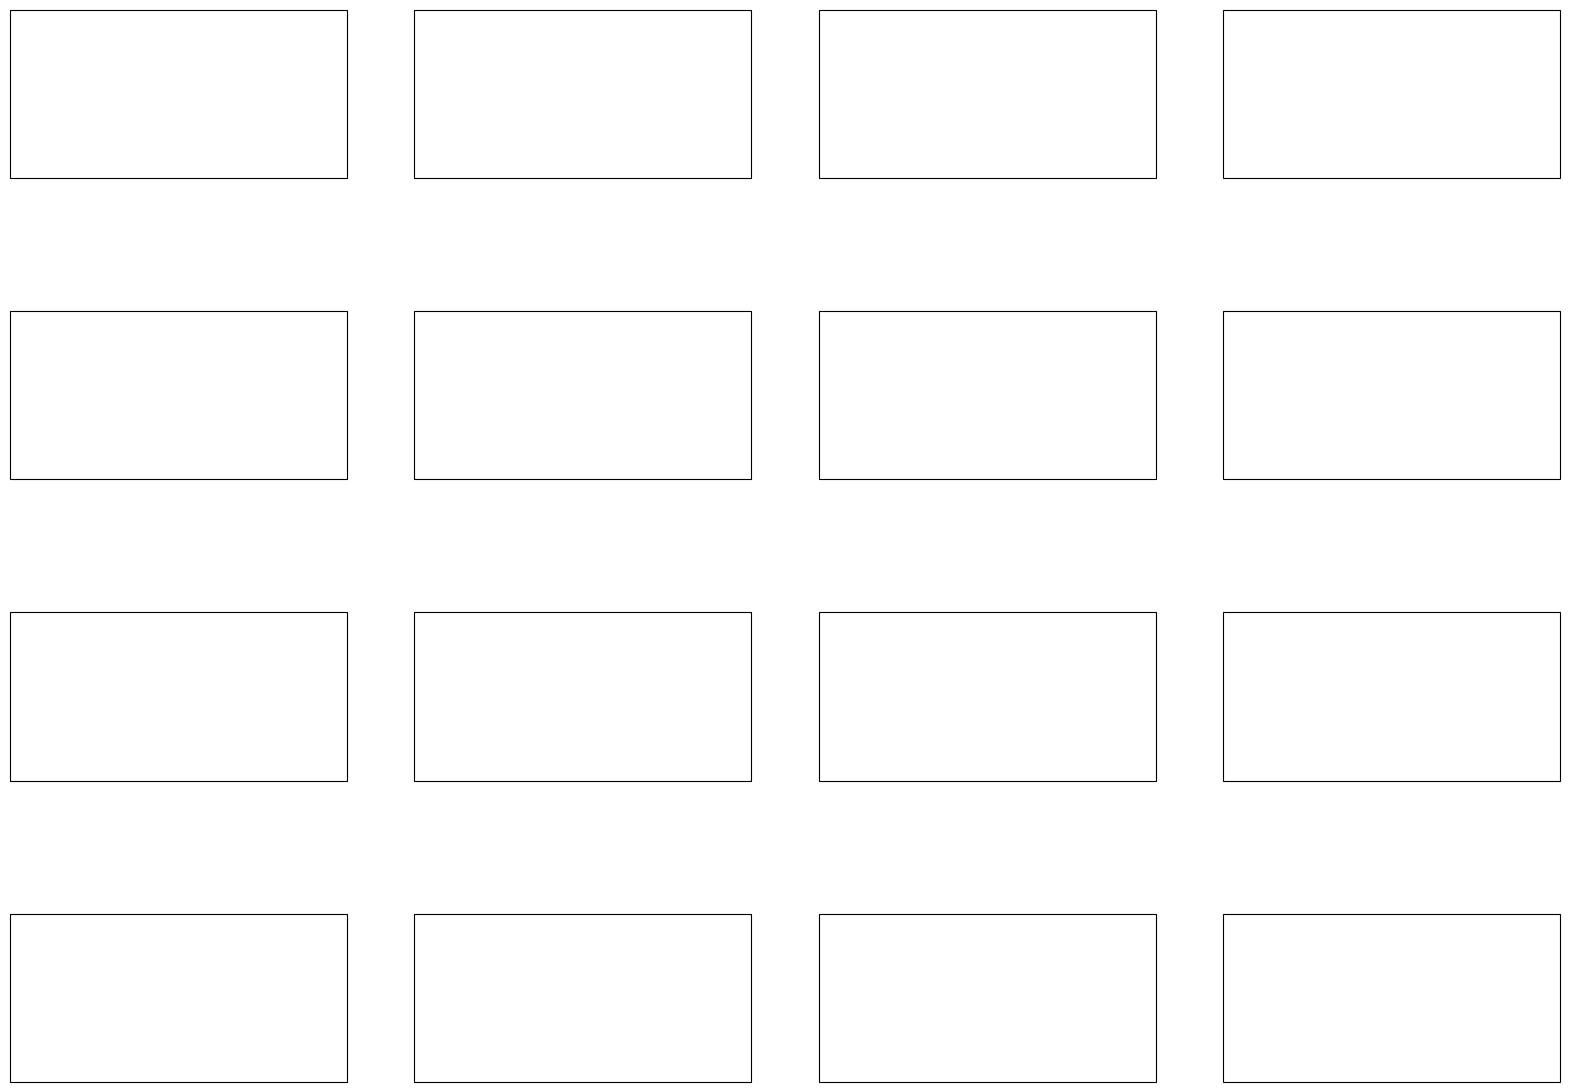

In [85]:
%%time
fig, ax = plt.subplots(4, 4, figsize=(20,15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # figsize is width, height

cmap = mpl.colormaps.get_cmap('seismic')

# variable longnames in column titles
col_titles = ["a) Integrated Water Vapor", "b) Zonal Wind at 850mb", "c) Meridional Wind at 850mb", "d) Sea Level Pressure"]
vmins = [-10,-10,-10,-10]
vmaxs = [10,10,10,10]
units = ["kg/m^2", "m/s", "m/s", "Pa"]

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):  # could also pull season names from dataset, but out of order
    for j, var in enumerate(('TMQ', 'U850', 'V850', 'PSL')): # could also pull var names from dataset
        lat = diff_smean.lat
        lon = diff_smean.lon
        pc = ax[i,j].pcolormesh(lon, lat, diff_smean[var].sel(season=season), cmap=cmap, vmin=vmins[j], vmax=vmaxs[j], transform=ccrs.PlateCarree())
        ax[i,j].coastlines(zorder=1)
        ax[i,j].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
        ax[i,j].set_ylabel(season, fontsize=12)
        ax[i,j].set_yticks([])
        if i==0:
            ax[i,j].set_title(col_titles[j], fontsize=12)
        if i==3:
            cbar = plt.colorbar(orientation='horizontal', extend='both', label=units[j])
            #cbar.ax.set_xlabel(units[j], fontsize=12);
    
# colorbar for TMQ
#cbar_1_ax = fig.add_axes([0.1, 0.07, 0.15, 0.02])
#cbar_1 = plt.colorbar(pc1, cax=cbar_1_ax, orientation='horizontal', extend='both')
#cbar_1.ax.set_xlabel('mm', fontsize=12);

# colorbar for U850
#cbar_2_ax = fig.add_axes([0.35, 0.07, 0.15, 0.02])
#cbar_2 = plt.colorbar(pc2, cax=cbar_2_ax, orientation='horizontal', extend='both')
#cbar_2.ax.set_xlabel('m/s', fontsize=12);

# colorbar for V850
#cbar_3_ax = fig.add_axes([0.6, 0.07, 0.15, 0.02])
#cbar_3 = plt.colorbar(pc3, cax=cbar_3_ax, orientation='horizontal', extend='both')
#cbar_3.ax.set_xlabel('m/s', fontsize=12);

# colorbar for PSL
#cbar_4_ax = fig.add_axes([0.85, 0.07, 0.15, 0.02])
#cbar_4 = plt.colorbar(pc, cax=cbar_3_ax, orientation='horizontal', extend='both')
#cbar_4.ax.set_xlabel('Pa', fontsize=12);

# add suptitle
fig.suptitle('CESM RCP8.5 - Historical Input Variable Differences, AR Timepoints', fontsize=16, y=0.94);

plt.subplots_adjust(wspace=0, hspace=0.1) 

plt.savefig('../figures/toSCP/CESM-allvars-AR_byseason_WUS_diff.png', bbox_inches='tight')

In [69]:
client.close()
cluster.close()